# Localized Potential Field Extrapolations

1. Download HMI LOS magnetogram
2. Download corresponding AIA 171 image
3. Crop both to FOV relevant to chosen AR
4. Reproject HMI using the planar screen approximation, putting the screen at the surface of the sun and setting the orientation of the screen using the center of the AR
5. Revive implementation of the Green's function potential field extrapolation
6. Use `streamtracer` to trace fieldlines in an HCC coordinate frame centered on the AR center (that also defined the planar screen orientation)

In [1]:
import matplotlib.pyplot as plt
import matplotlib.colors
import numba
import numpy as np
from streamtracer import VectorGrid,StreamTracer
import xarray

import astropy.units as u
from astropy.coordinates import SkyCoord, CartesianRepresentation, SphericalRepresentation
from astropy.visualization import ImageNormalize

import sunpy.map
from sunpy.net import Fido, attrs as a
from sunpy.coordinates import PlanarScreen, SphericalScreen, Helioprojective, HeliographicStonyhurst

In [2]:
q = Fido.search(
    a.Time('2011-02-12 15:00:00', end='2011-02-12 16:00:00', near='2011-02-12 15:32:42'),
    (a.Instrument.aia & a.Physobs.intensity & a.Wavelength(171*u.AA)) | (a.Instrument.hmi & a.Physobs.los_magnetic_field), 
)

In [3]:
files = Fido.fetch(q, path='../data/{instrument}')

Files Downloaded:   0%|          | 0/2 [00:00<?, ?file/s]

In [4]:
m_aia, m_hmi = sunpy.map.Map(files)

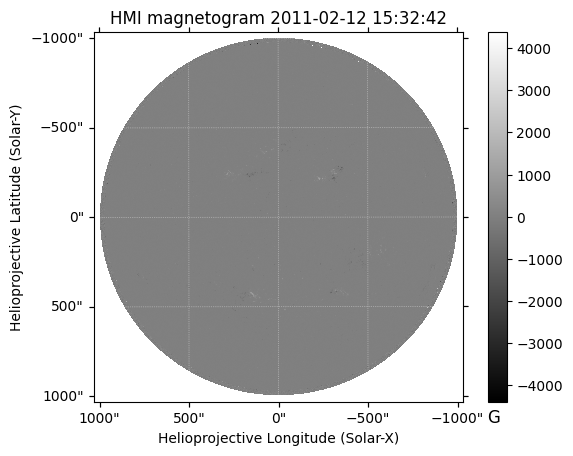

In [5]:
m_hmi.peek()

In [6]:
m_aia_cutout = m_aia.submap(
    SkyCoord(Tx=-475*u.arcsec, Ty=-400*u.arcsec, frame=m_aia.coordinate_frame),
    top_right=SkyCoord(Tx=-125*u.arcsec, Ty=-50*u.arcsec, frame=m_aia.coordinate_frame),
)

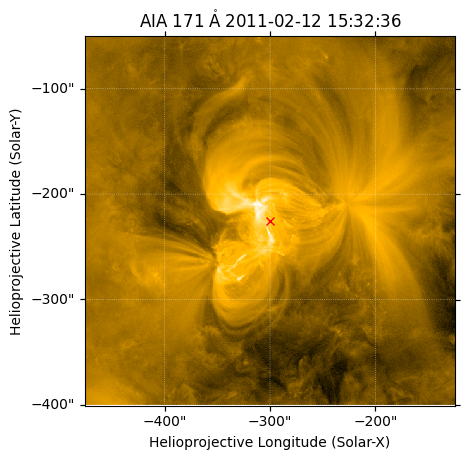

In [7]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
ax.plot_coord(m_aia_cutout.center, marker='x', color='r')

In [8]:
ar_center = m_aia_cutout.center.transform_to(HeliographicStonyhurst)

In [9]:
new_hpc_frame = Helioprojective(
    observer=HeliographicStonyhurst(lon=ar_center.lon,
                                    lat=ar_center.lat,
                                    radius=m_hmi.observer_coordinate.radius,
                                    obstime=m_hmi.reference_date),
    rsun=m_hmi.coordinate_frame.rsun,
)
new_header = sunpy.map.make_fitswcs_header(
    m_hmi.data.shape,
    SkyCoord(Tx=0,Ty=0,unit='arcsec',frame=new_hpc_frame),
    scale=u.Quantity(m_hmi.scale),
    observatory=m_hmi.observatory,
    instrument=m_hmi.instrument,
    wavelength=m_hmi.wavelength,
    unit=m_hmi.unit,
)

In [10]:
with PlanarScreen(ar_center, distance_from_center=ar_center.radius, ):
    m_hmi_skewed = m_hmi.reproject_to(new_header)
m_hmi_skewed = sunpy.map.Map(m_hmi_skewed.data, new_header)

2024-10-27 21:38:49 - reproject.common - INFO: Calling _reproject_full in non-dask mode


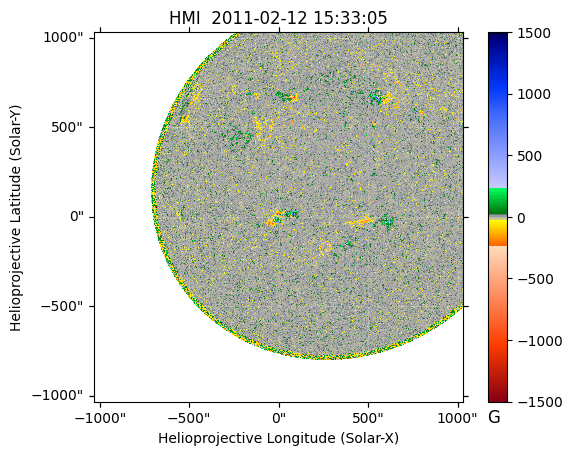

In [11]:
m_hmi_skewed.peek(norm=ImageNormalize(vmin=-1500, vmax=1500), cmap='hmimag')

Crop to AR and resample the boundary such that our extrapolation is tractable

In [12]:
m_hmi_ar_box = (
    m_hmi_skewed
    .submap(m_aia_cutout.bottom_left_coord,top_right=m_aia_cutout.top_right_coord)
    .resample([200,200]*u.pixel)
)

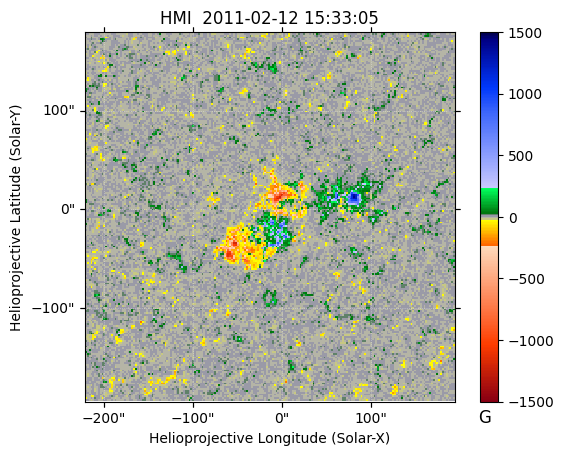

In [13]:
m_hmi_ar_box.peek(norm=ImageNormalize(vmin=-1500, vmax=1500),cmap='hmimag')

In [14]:
import sunpy.visualization.drawing

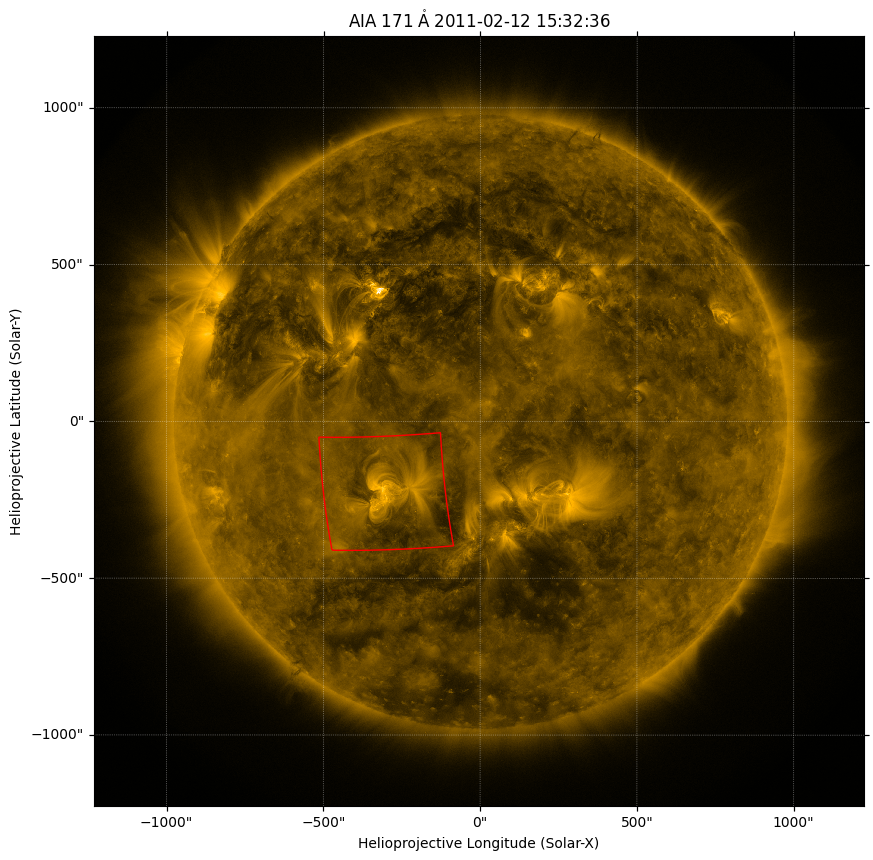

In [16]:
#%pdb
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection=m_aia)
m_aia.plot(axes=ax)
vis, hid = m_aia.draw_extent(m_hmi_ar_box.wcs, axes=ax, color='r')
#sunpy.visualization.drawing.extent(ax, m_hmi_ar_box.wcs, rsun=m_hmi_ar_box.rsun_meters, color='r', ls='-')
#ax.set_xlim(-100,700)
#ax.set_ylim(-100,700)
#plt.show()

(<matplotlib.patches.Polygon at 0x3ca677950>, None)

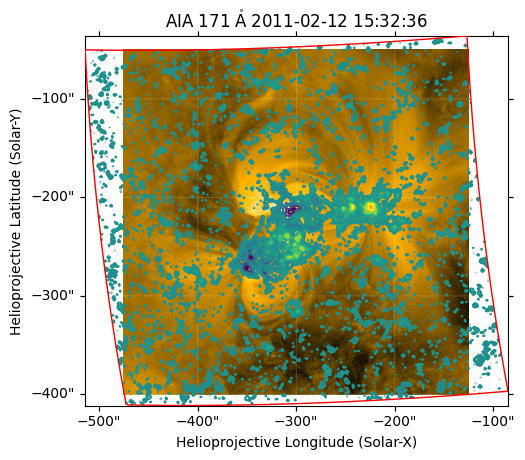

In [20]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
m_hmi_ar_box.draw_contours([-75,-50,-20,-10,-5,-2,-1,1,2,5,10,20,30,50,75,]*u.percent, axes=ax,cmap='viridis')
m_aia_cutout.draw_extent(m_hmi_ar_box.wcs, axes=ax, color='r')

Compute the norm of the vector to the observer in the HCC frame

In [14]:
hcc_frame = sunpy.coordinates.Heliocentric(observer=m_hmi_ar_box.observer_coordinate)

In [15]:
l_hat = m_hmi.observer_coordinate.transform_to(hcc_frame).cartesian
l_hat += CartesianRepresentation(0,0,1) * m_hmi_ar_box.rsun_meters
l_hat /= l_hat.norm()
#l_hat = CartesianRepresentation(0,0,1)

Choose $\Delta z$ and the shape of $z$ to be the same as $x$ and $y$

In [16]:
delta_xyz = (u.Quantity(m_hmi_ar_box.scale) * 1*u.pix).to(
    'Mm',
    equivalencies=sunpy.coordinates.utils.solar_angle_equivalency(m_hmi.observer_coordinate)
)
delta_xyz = np.append(delta_xyz, 1*u.Mm)#delta_xyz[0])
shape_xyz = np.round(u.Quantity(m_hmi_ar_box.dimensions).to_value('pix')).astype(int)
shape_xyz = np.append(shape_xyz, shape_xyz[0])

2024-10-24 15:32:59 - sunpy - INFO: Apparent body location accounts for 492.53 seconds of light travel time


INFO: Apparent body location accounts for 492.53 seconds of light travel time [sunpy.coordinates.ephemeris]


In [200]:
xyz_grid[-1][0]

<Quantity 664.0186859 Mm>

In [17]:
z_depth = -delta_xyz[-1] / np.sqrt(2*np.pi)

In [18]:
@numba.jit(nopython=True, fastmath=True, parallel=True, nogil=True)
def calculate_phi(phi, boundary, delta, shape, z_depth, l_hat):
    factor = 1. / (2. * np.pi) * delta[0] * delta[1]
    for i in numba.prange(shape[0]):
        for j in numba.prange(shape[1]):
            for k in numba.prange(shape[2]):
                Rz = k * delta[2] - z_depth
                lzRz = l_hat[2] * Rz
                for i_prime in range(shape[0]):
                    for j_prime in range(shape[1]):
                        Rx = delta[0] * (i - i_prime)
                        Ry = delta[1] * (j - j_prime)
                        R_mag = np.sqrt(Rx**2 + Ry**2 + Rz**2)
                        num = l_hat[2] + Rz / R_mag
                        denom = R_mag + lzRz + Rx*l_hat[0] + Ry*l_hat[1]
                        green = num / denom
                        phi[j, i, k] += boundary[j_prime, i_prime] * green * factor
    return phi


@u.quantity_input
def calculate_field(phi: u.G * u.cm, delta: u.cm):
    r"""
    Compute vector magnetic field.

    Calculate the vector magnetic field using the current-free approximation,

    .. math::
        \\vec{B} = -\\nabla\phi

    The gradient is computed numerically using a five-point stencil,

    .. math::
        \\frac{\partial B}{\partial x_i} \\approx -\left(\\frac{-B_{x_i}(x_i + 2\Delta x_i) + 8B_{x_i}(x_i + \Delta x_i) - 8B_{x_i}(x_i - \Delta x_i) + B_{x_i}(x_i - 2\Delta x_i)}{12\Delta x_i}\\right)

    Parameters
    ----------
    phi : `~astropy.units.Quantity`

    Returns
    -------
    B_field : `~synthesizAR.util.SpatialPair`
        x, y, and z components of the vector magnetic field in 3D
    """
    Bfield = u.Quantity(np.zeros(phi.shape+(3,)), 'G')
    # Take gradient using a five-point stencil
    Bfield[2:-2, 2:-2, 2:-2, 0] = -(phi[2:-2, :-4, 2:-2]
                                    - 8.*phi[2:-2, 1:-3, 2:-2]
                                    + 8.*phi[2:-2, 3:-1, 2:-2]
                                    - phi[2:-2, 4:, 2:-2])/12./delta[0]
    Bfield[2:-2, 2:-2, 2:-2, 1] = -(phi[:-4, 2:-2, 2:-2]
                                    - 8.*phi[1:-3, 2:-2, 2:-2]
                                    + 8.*phi[3:-1, 2:-2, 2:-2]
                                    - phi[4:, 2:-2, 2:-2])/12./delta[1]
    Bfield[2:-2, 2:-2, 2:-2, 2] = -(phi[2:-2, 2:-2, :-4]
                                    - 8.*phi[2:-2, 2:-2, 1:-3]
                                    + 8.*phi[2:-2, 2:-2, 3:-1]
                                    - phi[2:-2, 2:-2, 4:])/12./delta[2]
    # Set boundary conditions such that the last two cells in either direction in each dimension
    # are the same as the preceding cell.
    for i in range(Bfield.shape[-1]):
        for j in [0, 1]:
            Bfield[j, :, :, i] = Bfield[2, :, :, i]
            Bfield[:, j, :, i] = Bfield[:, 2, :, i]
            Bfield[:, :, j, i] = Bfield[:, :, 2, i]
        for j in [-2, -1]:
            Bfield[j, :, :, i] = Bfield[-3, :, :, i]
            Bfield[:, j, :, i] = Bfield[:, -3, :, i]
            Bfield[:, :, j, i] = Bfield[:, :, -3, i]

    return Bfield

In [19]:
phi = np.zeros(shape_xyz)
phi = calculate_phi(phi,
                    m_hmi_ar_box.quantity.to_value('G'),
                    delta_xyz.to_value('Mm'),
                    shape_xyz,
                    z_depth.to_value('Mm'),
                    l_hat.xyz.value)
phi = u.Quantity(phi, 'G Mm')
Bfield = calculate_field(phi, delta_xyz)

In [20]:
xyz_grid = u.Quantity([d*np.arange(s) for d,s in zip(delta_xyz,shape_xyz,strict=True)])

In [21]:
xyz_grid

<Quantity [[  0.        ,   1.48354774,   2.96709547,   4.45064321,
              5.93419094,   7.41773868,   8.90128641,  10.38483415,
             11.86838189,  13.35192962,  14.83547736,  16.31902509,
             17.80257283,  19.28612056,  20.7696683 ,  22.25321604,
             23.73676377,  25.22031151,  26.70385924,  28.18740698,
             29.67095472,  31.15450245,  32.63805019,  34.12159792,
             35.60514566,  37.08869339,  38.57224113,  40.05578887,
             41.5393366 ,  43.02288434,  44.50643207,  45.98997981,
             47.47352754,  48.95707528,  50.44062302,  51.92417075,
             53.40771849,  54.89126622,  56.37481396,  57.85836169,
             59.34190943,  60.82545717,  62.3090049 ,  63.79255264,
             65.27610037,  66.75964811,  68.24319584,  69.72674358,
             71.21029132,  72.69383905,  74.17738679,  75.66093452,
             77.14448226,  78.62803   ,  80.11157773,  81.59512547,
             83.0786732 ,  84.56222094,  86.0457

In [24]:
llc = m_hmi_ar_box.wcs.pixel_to_world(0,0).transform_to(hcc_frame)

In [25]:
xyz_grid += llc.cartesian.xyz[:,np.newaxis]

In [26]:
da = xarray.DataArray(
    Bfield.to_value('G'),
    dims=['x', 'y', 'z', 'component'],
    coords={
        'x': xarray.Variable(['x'], xyz_grid[0].to_value('Mm'), attrs={'unit':'Mm'}),
        'y': xarray.Variable(['y'], xyz_grid[1].to_value('Mm'), attrs={'unit':'Mm'}),
        'z': xarray.Variable(['z'], xyz_grid[2].to_value('Mm'), attrs={'unit':'Mm'}),
        'component': ['Bx','By','Bz'],
    },
    attrs={'unit':'G'}
)

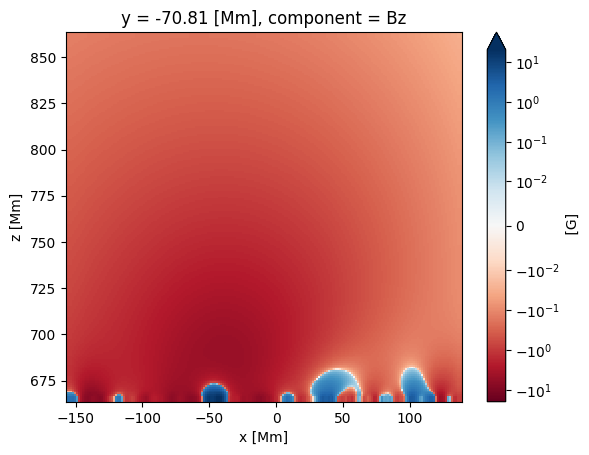

In [206]:
da.sel(component='Bz').isel(y=-150,).plot(
    x='x',
    y='z',
    norm=matplotlib.colors.SymLogNorm(1e-2,vmin=-20,vmax=20),
    cmap='RdBu'
)

In [266]:
tracer = StreamTracer(100000, 0.001)

In [267]:
vg = VectorGrid(
    da.data,
    grid_coords=xyz_grid.to_value('Mm'),
)

In [268]:
blc = SkyCoord(Tx=-100*u.arcsec, Ty=-75*u.arcsec, frame=m_hmi_ar_box.coordinate_frame)

In [272]:
m_hmi_ar_box_zoom = m_hmi_ar_box.submap(blc, width=250*u.arcsec, height=150*u.arcsec)
iy,ix = np.where(m_hmi_ar_box_zoom.data>1e-2*np.nanmax(m_hmi_ar_box_zoom.data))

In [273]:
with PlanarScreen(m_hmi_ar_box.observer_coordinate,
                  distance_from_center=llc.cartesian.z):
    seed_points = m_hmi_ar_box_zoom.wcs.array_index_to_world(iy,ix).transform_to(hcc_frame)

In [287]:
seed_points.z.to('Mm')

<Quantity [664.0186859, 664.0186859, 664.0186859, ..., 664.0186859,
           664.0186859, 664.0186859] Mm>

/Users/wtbarnes/mambaforge/envs/ar-evolution-survey/lib/python3.12/site-packages/astropy/visualization/wcsaxes/patches.py:196: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  super().__init__(vertices, **kwargs)


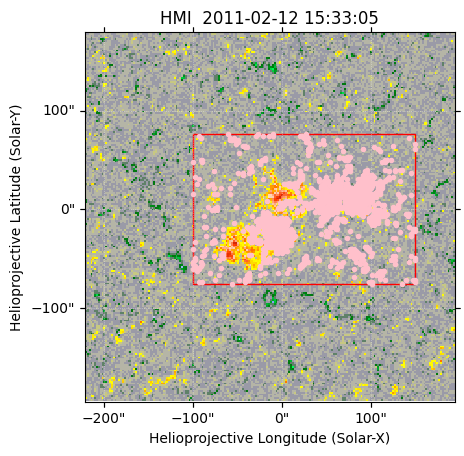

In [274]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_hmi_ar_box)
m_hmi_ar_box.plot(axes=ax,cmap='hmimag', norm=ImageNormalize(vmin=-1500,vmax=1500))
ax.plot_coord(seed_points, marker='.', color='pink', ls='')
m_hmi_ar_box.draw_quadrangle(m_hmi_ar_box_zoom.bottom_left_coord, top_right=m_hmi_ar_box_zoom.top_right_coord,
                             axes=ax, color='r')

In [275]:
tracer.trace(seed_points.cartesian.xyz.T.to_value('Mm'), vg, direction=1)

In [276]:
fieldlines = [SkyCoord(*sl.T, unit='Mm', frame=hcc_frame) for sl in tracer.xs]

In [277]:
def get_length(l):
    return l[1:].separation_3d(l[:-1]).sum()


def is_closed(l, tol=0.005*u.Rsun):
    return np.fabs(np.diff(l.spherical.distance[[0,-1]]) ) < tol


In [278]:
length_bounds = [10,1000] * u.Mm

In [279]:
fieldlines_filtered = []
for f in fieldlines:
    if not is_closed(f):
        continue
    if length_bounds[0] <= get_length(f) <= length_bounds[1]:
        fieldlines_filtered.append(f)

In [280]:
len(fieldlines_filtered)

239

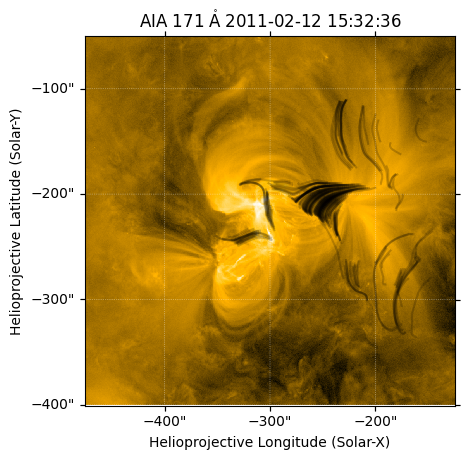

In [282]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
#ax.plot_coord(seed_points, marker='.', color='pink', ls='')
for f in fieldlines_filtered:
    ax.plot_coord(f, color='k', alpha=.2)

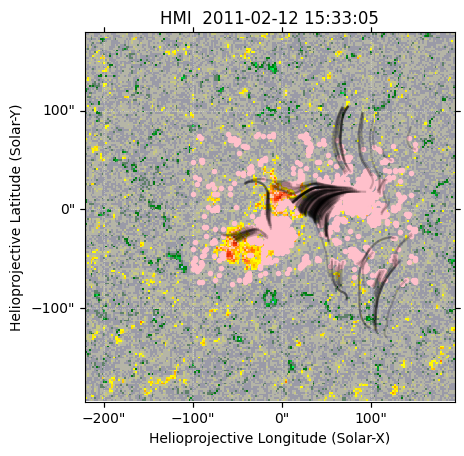

In [288]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_hmi_ar_box)
m_hmi_ar_box.plot(axes=ax,
                  cmap='hmimag',
                  norm=ImageNormalize(vmin=-1500,vmax=1500))
ax.plot_coord(seed_points, marker='.', color='pink', ls='')
for f in fieldlines_filtered:
    ax.plot_coord(f, color='k', alpha=.2)

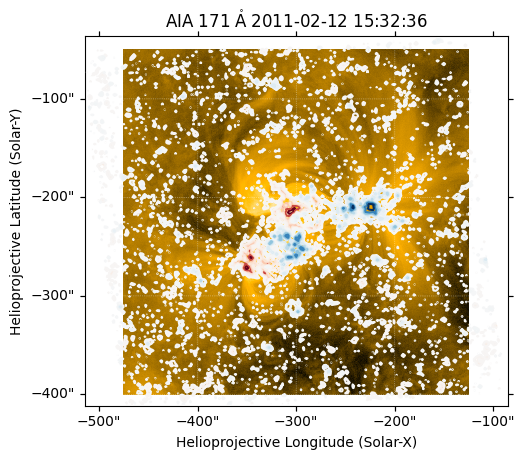

In [305]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
m_hmi_ar_box.draw_contours([-75,-50,-20,-10,-5,-2,-1,1,2,5,10,20,30,50,75,]*u.percent, axes=ax,cmap='RdBu')

In [307]:
m_hmi_ar_box.data.shape

(200, 200)

In [306]:
m_hmi_ar_box.dimensions.y

<Quantity 200. pix>

In [346]:
corners = list(set(list(itertools.permutations((0, 0, m_hmi_ar_box.data.shape[1]-1, m_hmi_ar_box.data.shape[0]-1),2))))

In [351]:
corners

[(199, 0), (0, 199), (199, 199), (0, 0)]

In [389]:
m_hmi_ar_box.wcs.pixel_shape

(200, 200)

In [21]:
n_points = 1000
corners = np.array([
    (0, 0),
    (0, m_hmi_ar_box.data.shape[0]-1),
    (m_hmi_ar_box.data.shape[1]-1, m_hmi_ar_box.data.shape[0]-1),
    (m_hmi_ar_box.data.shape[1]-1, 0),
])
edges = np.array([
    (corners[0], corners[1]),
    (corners[1], corners[2]),
    (corners[2], corners[3]),
    (corners[3], corners[0]),
])
edges = np.array([(np.linspace(*e[:,0],n_points), np.linspace(*e[:,1],n_points)) for e in edges])
#np.arange()

In [22]:
world_edges = [m_hmi_ar_box.wcs.pixel_to_world(*e) for e in edges]

In [23]:
world_edges

[<SkyCoord (Helioprojective: obstime=2011-02-12T15:33:05.000, rsun=696000.0 km, observer=<HeliographicStonyhurst Coordinate (obstime=2011-02-12T15:33:05.000, rsun=696000.0 km): (lon, lat, radius) in (deg, deg, m)
     (-19.04228208, -19.67175, 1.47657723e+11)>): (Tx, Ty) in arcsec
     [(-219.81646413, -1.93194298e+02), (-219.81646413, -1.92822160e+02),
      (-219.81646413, -1.92450022e+02), (-219.81646413, -1.92077884e+02),
      (-219.81646413, -1.91705746e+02), (-219.81646413, -1.91333608e+02),
      (-219.81646413, -1.90961471e+02), (-219.81646413, -1.90589333e+02),
      (-219.81646413, -1.90217195e+02), (-219.81646413, -1.89845057e+02),
      (-219.81646413, -1.89472919e+02), (-219.81646413, -1.89100781e+02),
      (-219.81646413, -1.88728643e+02), (-219.81646413, -1.88356505e+02),
      (-219.81646413, -1.87984368e+02), (-219.81646413, -1.87612230e+02),
      (-219.81646413, -1.87240092e+02), (-219.81646413, -1.86867954e+02),
      (-219.81646413, -1.86495816e+02), (-219.816464

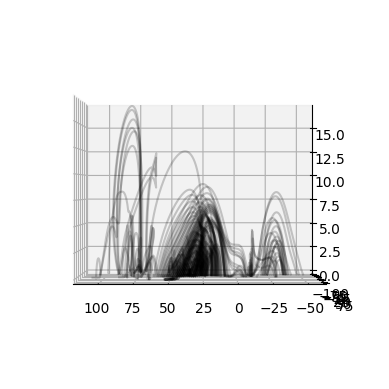

In [283]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
for f in fieldlines_filtered:
    ax.plot(f.x,f.y,f.z-xyz_grid[-1,0], color='k', alpha=0.2)
ax.view_init(elev=0, azim=90, roll=0)

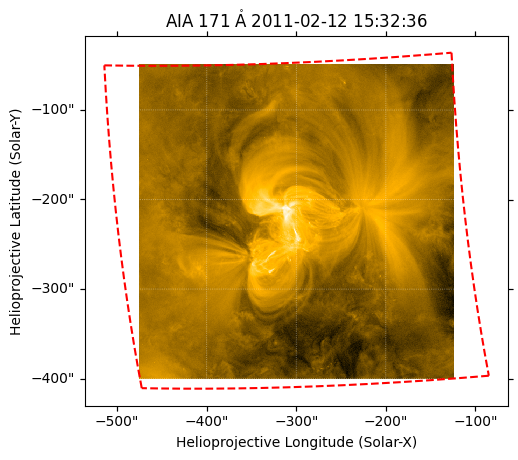

In [387]:
fig = plt.figure()
ax = fig.add_subplot(projection=m_aia_cutout)
m_aia_cutout.plot(axes=ax)
for we in world_edges:
    ax.plot_coord(we, color='r', ls='--')

(array([82., 54., 37., 28., 23.,  6.,  2.,  2.,  2.,  3.]),
 array([10.256     , 19.2303    , 28.2046    , 37.17889999, 46.15319999,
        55.12749999, 64.10179999, 73.07609999, 82.05039999, 91.02469999,
        99.99899999]),
 <BarContainer object of 10 artists>)

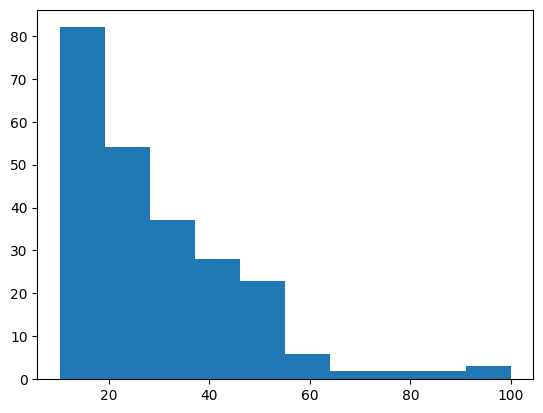

In [284]:
plt.hist(list(map(get_length, fieldlines_filtered)))

In [35]:
xy = []
for _ in range(5):
    xy += [[np.random.rand(10), np.random.rand(10)]]
xy = np.hstack(xy)

In [38]:
xy.shape

(2, 50)

In [40]:
foo = 'foo'
for f in foo:
    print(f)
    print(next(foo))

f


TypeError: 'str' object is not an iterator